In [ ]:
!pip install wandb

In [ ]:
import wandb
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [ ]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import wandb
from pytorch_msssim import ssim

In [ ]:
wandb.login()
wandb.init(project='polygon-color-unet')

<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: vspoorthi-2020 (vspoorthi) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
IMG_SIZE = 128
BATCH_SIZE = 16
NUM_EPOCHS = 20
NUM_COLORS = 8
LR = 1e-3
COLOR_LIST = ["red", "green", "blue", "yellow", "orange", "purple", "cyan", "magenta"]

training_dataset_path = '/content/drive/MyDrive/dataset_Ayna/training'
validation_dataset_path = '/content/drive/MyDrive/dataset_Ayna/validation'


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def color_to_onehot(color):
    vec = [0] * len(COLOR_LIST)
    if color not in COLOR_LIST:
        raise ValueError(f"Color '{color}' not in COLOR_LIST")
    vec[COLOR_LIST.index(color)] = 1
    return np.array(vec)

def load_dataset_from_path(dataset_path):
    with open(os.path.join(dataset_path, 'data.json')) as f:
        data_json = json.load(f)

    inputs_dir = os.path.join(dataset_path, 'inputs')
    outputs_dir = os.path.join(dataset_path, 'outputs')

    data_list = []
    for item in data_json:
        data_list.append({
            'input': os.path.join(inputs_dir, item['input_polygon']),
            'output': os.path.join(outputs_dir, item['output_image']),
            'color': item['colour']
        })
    return data_list

transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor()
])

class PolygonColorDataset(Dataset):
    def __init__(self, data_list, transform=None):
        self.data_list = data_list
        self.transform = transform or T.ToTensor()

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        item = self.data_list[idx]
        polygon_img = Image.open(item['input']).convert('RGB')
        output_img = Image.open(item['output']).convert('RGB')
        color_vec = torch.tensor(color_to_onehot(item['color'])).float()
        if self.transform:
            polygon_img = self.transform(polygon_img)
            output_img = self.transform(output_img)
        return polygon_img, color_vec, output_img

train_dataset = PolygonColorDataset(load_dataset_from_path(training_dataset_path), transform)
val_dataset = PolygonColorDataset(load_dataset_from_path(validation_dataset_path), transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, num_colors=8):
        super().__init__()
        input_channels = in_channels + num_colors
        self.inc = DoubleConv(input_channels, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256, 512))

        self.up1_transpose = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.up1_conv = DoubleConv(512, 256)
        self.up2_transpose = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.up2_conv = DoubleConv(256, 128)
        self.up3_transpose = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.up3_conv = DoubleConv(128, 64)
        self.outc = nn.Conv2d(64, out_channels, 1)

    def forward(self, x, color_vec):
        b, _, h, w = x.size()
        color_expand = color_vec.unsqueeze(2).unsqueeze(3).expand(b, color_vec.shape[1], h, w)
        x = torch.cat([x, color_expand], dim=1)

        c1 = self.inc(x)
        c2 = self.down1(c1)
        c3 = self.down2(c2)
        c4 = self.down3(c3)

        u1 = self.up1_transpose(c4)
        if u1.shape[2:] != c3.shape[2:]:
            u1 = nn.functional.interpolate(u1, size=c3.shape[2:], mode='bilinear', align_corners=False)
        u1 = self.up1_conv(torch.cat([u1, c3], dim=1))

        u2 = self.up2_transpose(u1)
        if u2.shape[2:] != c2.shape[2:]:
            u2 = nn.functional.interpolate(u2, size=c2.shape[2:], mode='bilinear', align_corners=False)
        u2 = self.up2_conv(torch.cat([u2, c2], dim=1))

        u3 = self.up3_transpose(u2)
        if u3.shape[2:] != c1.shape[2:]:
            u3 = nn.functional.interpolate(u3, size=c1.shape[2:], mode='bilinear', align_corners=False)
        u3 = self.up3_conv(torch.cat([u3, c1], dim=1))

        return torch.sigmoid(self.outc(u3))


In [ ]:
model = UNet(in_channels=3, out_channels=3, num_colors=NUM_COLORS).to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.MSELoss()
best_val_ssim = -float('inf')

print(f"Total trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

def psnr(pred, target, max_val=1.0):
    mse = torch.mean((pred - target) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * torch.log10(max_val / torch.sqrt(mse))

def validate():
    model.eval()
    total_loss = total_mae = total_psnr = total_ssim = 0

    with torch.no_grad():
        for polygon_img, color_vec, target_img in val_loader:
            polygon_img, target_img, color_vec = polygon_img.to(device), target_img.to(device), color_vec.to(device)
            preds = model(polygon_img, color_vec)

            total_loss += criterion(preds, target_img).item()
            total_mae += torch.mean(torch.abs(preds - target_img)).item()
            total_psnr += psnr(preds, target_img).item()
            total_ssim += ssim(preds, target_img, data_range=1.0, size_average=True).item()

    count = len(val_loader)
    return total_loss/count, total_mae/count, total_psnr/count, total_ssim/count

def train():
    global best_val_ssim
    for epoch in range(NUM_EPOCHS):
        model.train()
        total_loss = 0

        for polygon_img, color_vec, target_img in train_loader:
            polygon_img, target_img, color_vec = polygon_img.to(device), target_img.to(device), color_vec.to(device)
            preds = model(polygon_img, color_vec)

            loss = criterion(preds, target_img)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        val_loss, val_mae, val_psnr, val_ssim = validate()

        wandb.log({
            'epoch': epoch+1,
            'train_loss': avg_train_loss,
            'val_loss': val_loss,
            'val_mae': val_mae,
            'val_psnr': val_psnr,
            'val_ssim': val_ssim
        })

        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f} | MAE: {val_mae:.4f} | PSNR: {val_psnr:.2f} | SSIM: {val_ssim:.4f}")

        if val_ssim > best_val_ssim:
            best_val_ssim = val_ssim
            torch.save(model.state_dict(), '/content/drive/MyDrive/best_model.pth')
            print("💾 Saved best model (based on SSIM)!")

    print("🎉 Training completed!")

train()


Total trainable parameters: 7,707,715
Epoch [1/20] Train Loss: 0.2072 | Val Loss: 0.2422 | MAE: 0.4920 | PSNR: 6.16 | SSIM: 0.7207
💾 Saved best model (based on SSIM)!
Epoch [2/20] Train Loss: 0.1669 | Val Loss: 0.2213 | MAE: 0.4699 | PSNR: 6.55 | SSIM: 0.7384
💾 Saved best model (based on SSIM)!
Epoch [3/20] Train Loss: 0.1430 | Val Loss: 0.1942 | MAE: 0.4389 | PSNR: 7.12 | SSIM: 0.7615
💾 Saved best model (based on SSIM)!
Epoch [4/20] Train Loss: 0.1256 | Val Loss: 0.1633 | MAE: 0.3994 | PSNR: 7.87 | SSIM: 0.7884
💾 Saved best model (based on SSIM)!
Epoch [5/20] Train Loss: 0.1139 | Val Loss: 0.1339 | MAE: 0.3560 | PSNR: 8.73 | SSIM: 0.8137
💾 Saved best model (based on SSIM)!
Epoch [6/20] Train Loss: 0.0955 | Val Loss: 0.1102 | MAE: 0.3158 | PSNR: 9.58 | SSIM: 0.8265
💾 Saved best model (based on SSIM)!
Epoch [7/20] Train Loss: 0.0855 | Val Loss: 0.0937 | MAE: 0.2859 | PSNR: 10.28 | SSIM: 0.8375
💾 Saved best model (based on SSIM)!
Epoch [8/20] Train Loss: 0.0680 | Val Loss: 0.0785 | MAE: 

In [ ]:
!pip install pytorch-msssim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
def generate_colored_polygon(polygon_image_path, color_name):
    """Generate colored polygon with the trained model"""
    model = UNet(in_channels=3, out_channels=3, num_colors=8).to(device)
    model.load_state_dict(torch.load('/content/drive/MyDrive/best_model.pth'))
    model.eval()

    polygon_img = Image.open(polygon_image_path).convert('RGB')
    original_img = polygon_img.copy()
    polygon_img = transform(polygon_img).unsqueeze(0).to(device)

    color_vec = torch.tensor(color_to_onehot(color_name)).float().to(device).unsqueeze(0)

    with torch.no_grad():
        pred = model(polygon_img, color_vec)

    pred_img = pred.squeeze(0).cpu().permute(1, 2, 0).numpy()
    pred_img = np.clip(pred_img, 0, 1)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Original Input")
    plt.imshow(original_img)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Processed Input")
    plt.imshow(polygon_img.squeeze(0).cpu().permute(1, 2, 0))
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title(f"Generated {color_name.title()} Polygon")
    plt.imshow(pred_img)
    plt.axis('off')

    plt.tight_layout()
    plt.show()
    print(f"✅ Successfully generated {color_name} polygon!")


Dropdown(description='Shape:', options=('circle', 'diamond', 'hexagon', 'octagon', 'pentagon', 'square', 'star…

Dropdown(description='Color:', options=('red', 'green', 'blue', 'yellow', 'orange', 'purple', 'cyan', 'magenta…

Button(description='Generate Colored Polygon', style=ButtonStyle())

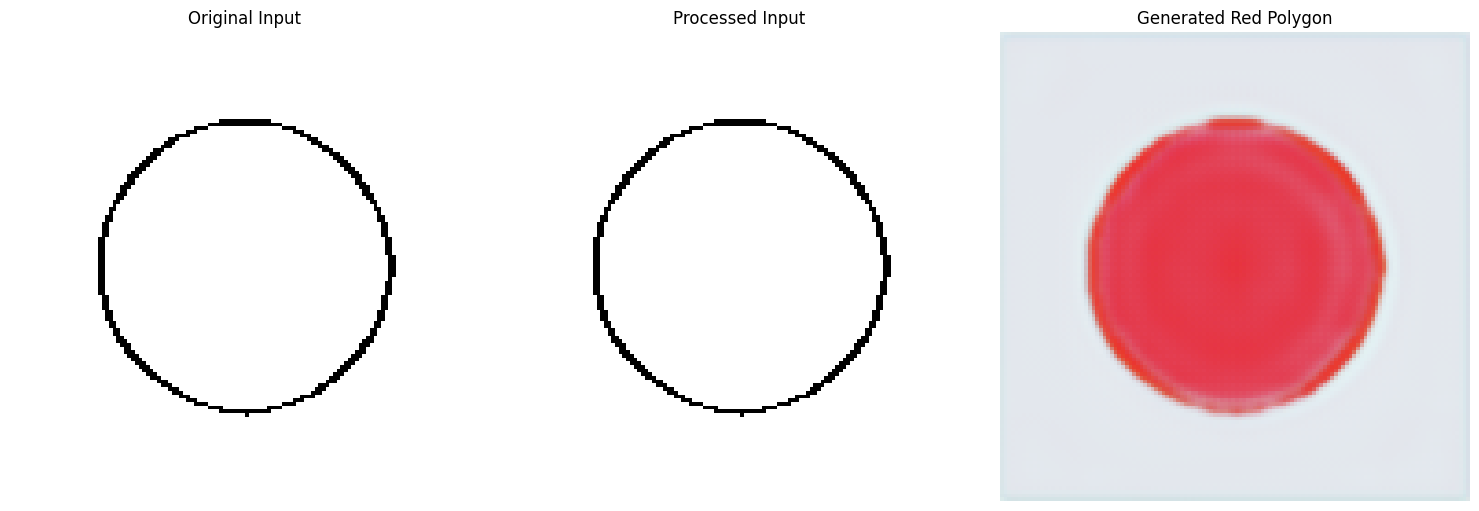

✅ Successfully generated red polygon!


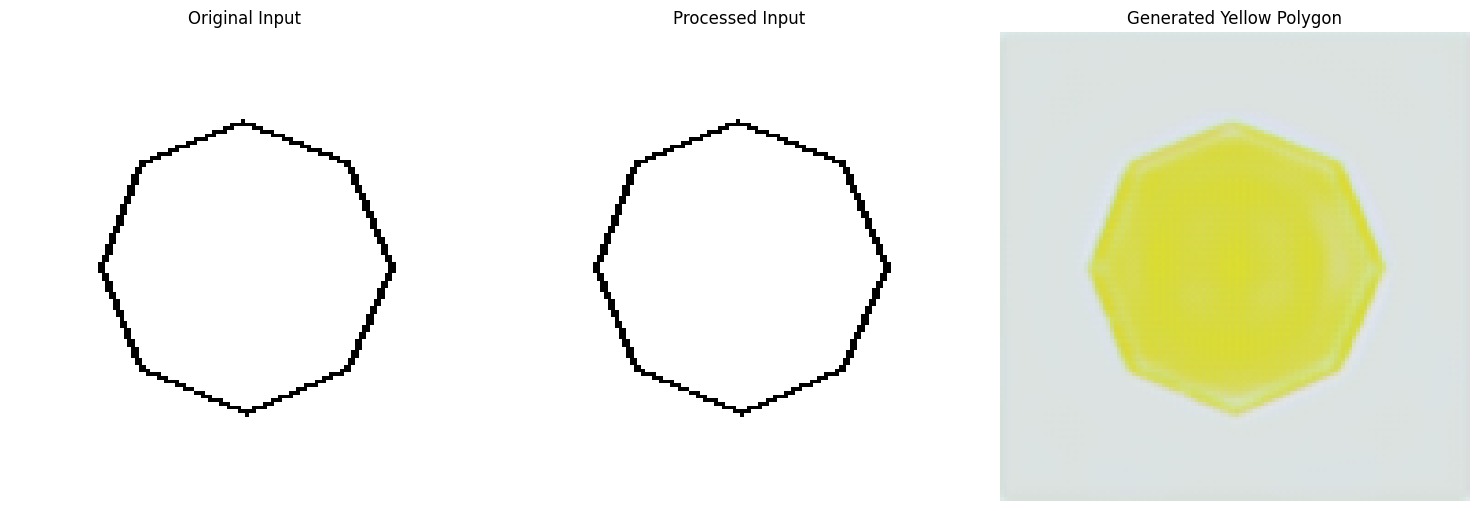

✅ Successfully generated yellow polygon!


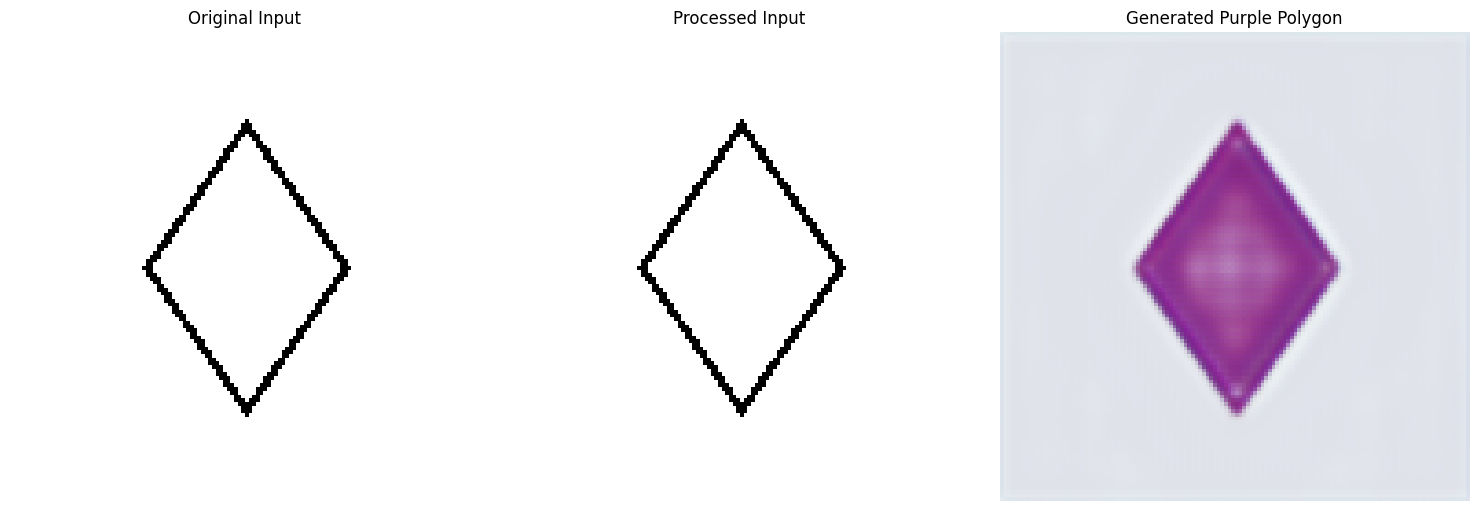

✅ Successfully generated purple polygon!


In [ ]:
import os
import ipywidgets as widgets
from IPython.display import display

training_dataset_path = '/content/drive/MyDrive/dataset_Ayna/training'
COLOR_LIST = ["red", "green", "blue", "yellow", "orange", "purple", "cyan", "magenta"]

def colab_prompt_generate():
    shape_dir = os.path.join(training_dataset_path, 'inputs')
    shape_names = sorted([f.split('.')[0] for f in os.listdir(shape_dir) if f.endswith('.png')])

    shape_dropdown = widgets.Dropdown(
        options=shape_names,
        description='Shape:',
        style={'description_width': 'initial'}
    )

    color_dropdown = widgets.Dropdown(
        options=COLOR_LIST,
        description='Color:',
        style={'description_width': 'initial'}
    )

    def on_button_click(b):
        image_path = os.path.join(shape_dir, f"{shape_dropdown.value}.png")
        generate_colored_polygon(image_path, color_dropdown.value)

    button = widgets.Button(description="Generate Colored Polygon")
    button.on_click(on_button_click)

    display(shape_dropdown, color_dropdown, button)

colab_prompt_generate()
